<a href="https://colab.research.google.com/github/MahmudShuvo/Autism-Detection-using-Deep-Learning/blob/main/Latest_EfficientnetB4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install split_folders

In [2]:
import os
import shutil
import splitfolders
import tensorflow as tf
import seaborn as sns
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("float32")
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense,Activation,Dropout,Conv2D,MaxPooling2D,BatchNormalization,Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import itertools
import matplotlib.pyplot as plt
import datetime
import matplotlib.image as mping
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

In [4]:
import os
import splitfolders

# Define the path to the input folder
input_folder = "/content/drive/MyDrive/AutismDataset/consolidated"

# Define the path to the output folder
output_folder = "/content/output"

# Split the data into train, validation, and test sets
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.1, 0.1))


Copying files: 2940 files [01:32, 31.67 files/s] 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define the directories for training, testing, and validation
train_dir = "output/train"
test_dir = "output/test"
val_dir = "output/val"

# Create datasets for training, testing, and validation
train_data = image_dataset_from_directory(
    train_dir,
    batch_size=32,
    image_size=(224, 224),
    label_mode='categorical',
    shuffle=True,
    seed=42
)

test_data = image_dataset_from_directory(
    test_dir,
    batch_size=32,
    image_size=(224, 224),
    label_mode='categorical',
    shuffle=False,
    seed=42
)

val_data = image_dataset_from_directory(
    val_dir,
    batch_size=32,
    image_size=(224, 224),
    label_mode='categorical',
    shuffle=False,
    seed=42
)


Found 2352 files belonging to 2 classes.
Found 294 files belonging to 2 classes.
Found 294 files belonging to 2 classes.


In [6]:
class_names = train_data.class_names
class_count = len(class_names)

print("Class Names:", class_names)
print("Number of Classes:", class_count)


Class Names: ['Autistic', 'Non_Autistic']
Number of Classes: 2


In [7]:
from tqdm import tqdm

samples = []
x = 0
for item in tqdm(train_data.unbatch()):
    if x == 10:
        break
    samples.append([item[0], item[1]])
    x += 1


10it [00:00, 15.42it/s]


In [8]:
import tensorflow as tf

images = []
labels = []

for sample in samples:
    images.append(sample[0])
    label_index = tf.argmax(sample[1])
    labels.append(class_names[label_index])

print("Number of Images:", len(images))
print("Number of Labels:", len(labels))


Number of Images: 10
Number of Labels: 10


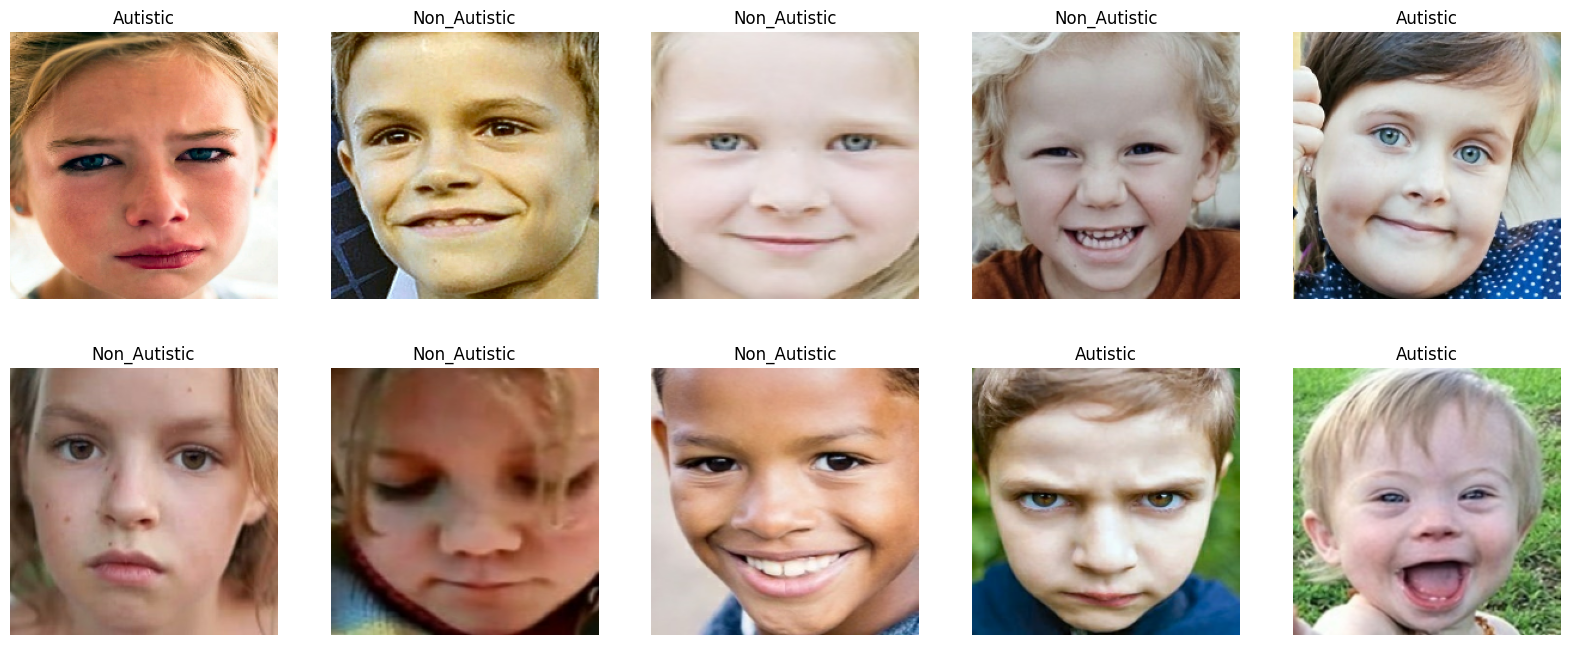

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 8))
rows = 2
cols = 5
x = 1

for image, label in zip(images, labels):
    ax = fig.add_subplot(rows, cols, x)
    ax.imshow(image/255.)  # Assuming the image data is normalized to [0, 1]
    ax.axis("off")
    ax.set_title(label)
    x += 1

plt.show()


In [10]:
input_shape = (224, 224, 3)

In [11]:


def create_early_stopper():
    earlystopper = tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=3,
        restore_best_weights=True,
        min_delta=0.001,
        verbose=1
    )
    return earlystopper


In [12]:
model_name = 'EfficientNetB4'
base_model = tf.keras.applications.EfficientNetB4(
    include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling='max')

71686520/71686520 [==============================] - 0s 0us/step


In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf

# Define additional layers
x = base_model.output
x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.002)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.45, seed=42)(x)
output = Dense(class_count, activation='softmax')(x)

# Construct the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [14]:
early_stopper = tf.keras.callbacks.EarlyStopping(patience=5, min_delta=0.01, verbose=1)

In [15]:
from tensorflow.keras.layers import GlobalAveragePooling2D

# Define EfficientNetB4 base model
base_model = tf.keras.applications.EfficientNetB4(
    include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling=None)

# Add GlobalAveragePooling2D layer to reduce the number of parameters
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
output = Dense(class_count, activation='softmax')(x)

# Construct the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [16]:
# Train the model
history = model.fit(train_data,
                    epochs=60,
                    validation_data=val_data,
                    callbacks=[early_stopper])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data)
print("Test Accuracy:", test_accuracy)

Epoch 1/60
74/74 [==============================] - 139s 791ms/step - loss: 0.5678 - accuracy: 0.7130 - val_loss: 0.5383 - val_accuracy: 0.6871
Epoch 2/60
74/74 [==============================] - 51s 686ms/step - loss: 0.2951 - accuracy: 0.8865 - val_loss: 0.4217 - val_accuracy: 0.7823
Epoch 3/60
74/74 [==============================] - 50s 677ms/step - loss: 0.1336 - accuracy: 0.9541 - val_loss: 0.3837 - val_accuracy: 0.8537
Epoch 4/60
74/74 [==============================] - 51s 683ms/step - loss: 0.0634 - accuracy: 0.9813 - val_loss: 0.4155 - val_accuracy: 0.8333
Epoch 5/60
74/74 [==============================] - 50s 676ms/step - loss: 0.0385 - accuracy: 0.9885 - val_loss: 0.4400 - val_accuracy: 0.8537
Epoch 6/60
74/74 [==============================] - 51s 679ms/step - loss: 0.0377 - accuracy: 0.9885 - val_loss: 0.5072 - val_accuracy: 0.8265
Epoch 7/60
74/74 [==============================] - 51s 679ms/step - loss: 0.0276 - accuracy: 0.9915 - val_loss: 0.4216 - val_accuracy: 0.860

In [19]:
from sklearn.metrics import roc_auc_score
# Make predictions on the test data
y_pred_probs = model.predict(test_data)

# Extract true labels from test data
y_true = np.concatenate([y.numpy() for x, y in test_data], axis=0)

# Calculate AUC for each class
auc = roc_auc_score(y_true, y_pred_probs, multi_class='ovr')
print("AUC Score:", auc)

10/10 [==============================] - 1s 145ms/step
AUC Score: 0.943403211624786


1/1 [==============================] - 0s 37ms/step


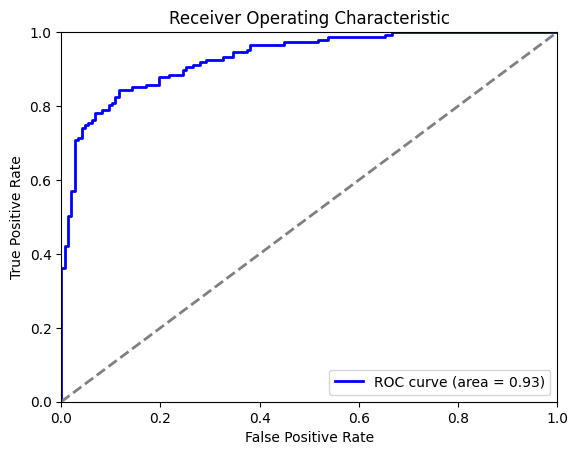

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import tensorflow as tf

# Assuming you have a trained model named `model`

# Get the true labels and predictions for the validation set
y_true = []
y_pred = []

for images, labels in val_data:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(predictions)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# If you have categorical labels, convert them to binary for ROC AUC computation
# Assuming binary classification for simplicity. Adjust for multi-class if necessary
y_true_binary = y_true[:, 1]  # Assuming the positive class is at index 1
y_pred_binary = y_pred[:, 1]  # Assuming the positive class is at index 1

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true_binary, y_pred_binary)
auc = roc_auc_score(y_true_binary, y_pred_binary)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Corrected line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

1/1 [==============================] - 0s 105ms/step


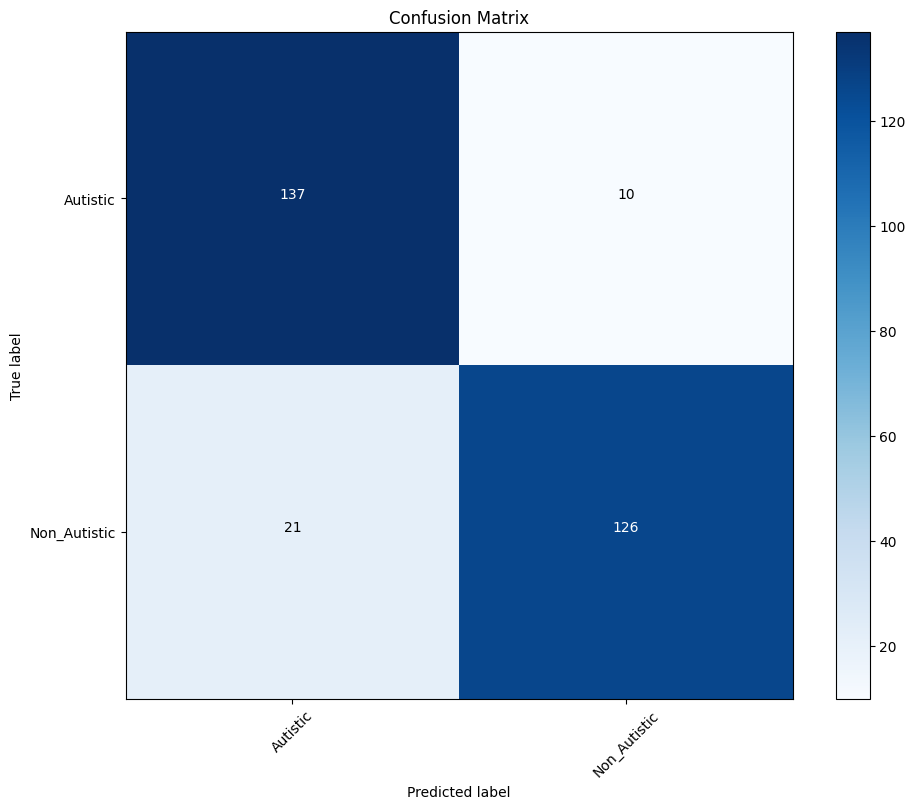

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Get true labels and predicted labels
true_labels = []
predicted_labels = []

for images, labels in test_data:
    true_labels.extend(np.argmax(labels.numpy(), axis=1))
    predicted_labels.extend(np.argmax(model.predict(images), axis=1))

# Calculate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


In [22]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.8967795979151154
Recall: 0.8945578231292517
F1 Score: 0.894410009847651


1/1 [==============================] - 0s 39ms/step


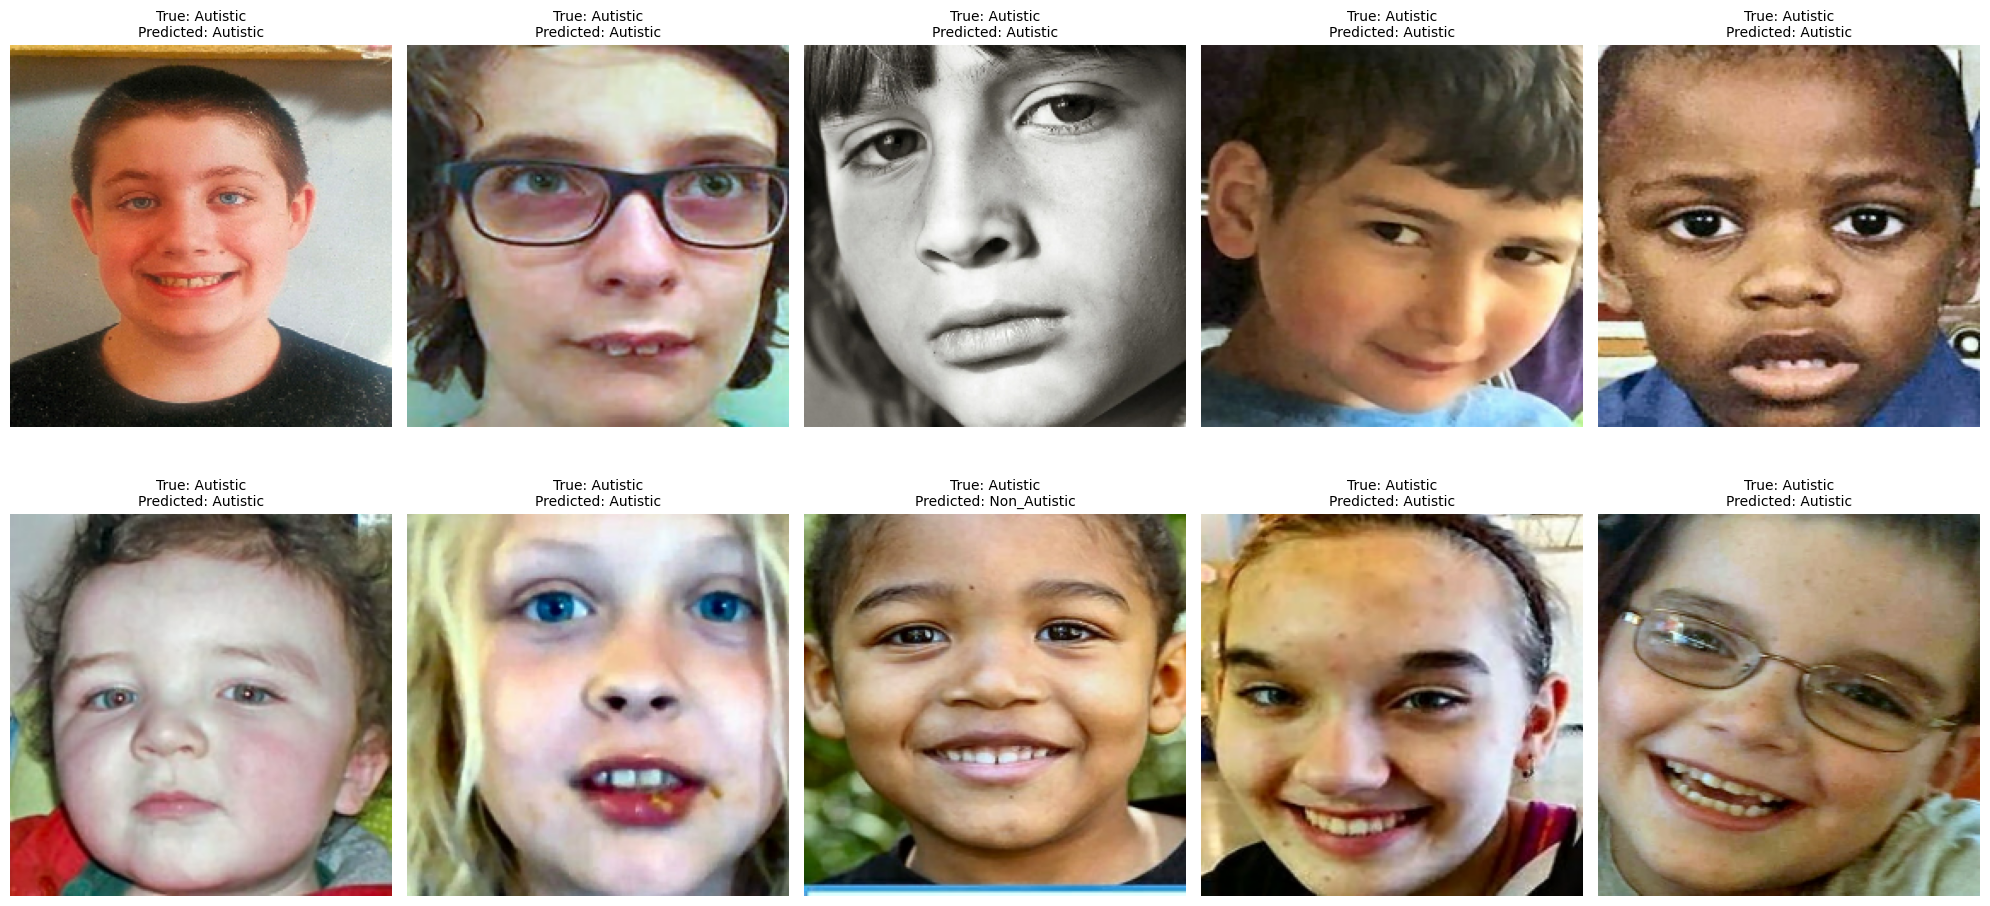

In [23]:
import matplotlib.pyplot as plt

# Function to plot sample images with true and predicted labels
def plot_sample_predictions(test_data, model, class_names, num_images=10, fontsize=10):
    plt.figure(figsize=(20, 10))
    for images, labels in test_data.take(2):  # Take one batch of images from the test dataset #1
        predictions = model.predict(images)
        for i in range(num_images):  # Plot specified number of sample images
            ax = plt.subplot(2, num_images//2, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            true_label = class_names[np.argmax(labels[i])]
            predicted_label = class_names[np.argmax(predictions[i])]
            plt.title(f'True: {true_label}\nPredicted: {predicted_label}', fontsize=fontsize)
            plt.axis("off")
    plt.tight_layout()
    plt.show()

# Example usage
plot_sample_predictions(test_data, model, class_names, num_images=10, fontsize=10)



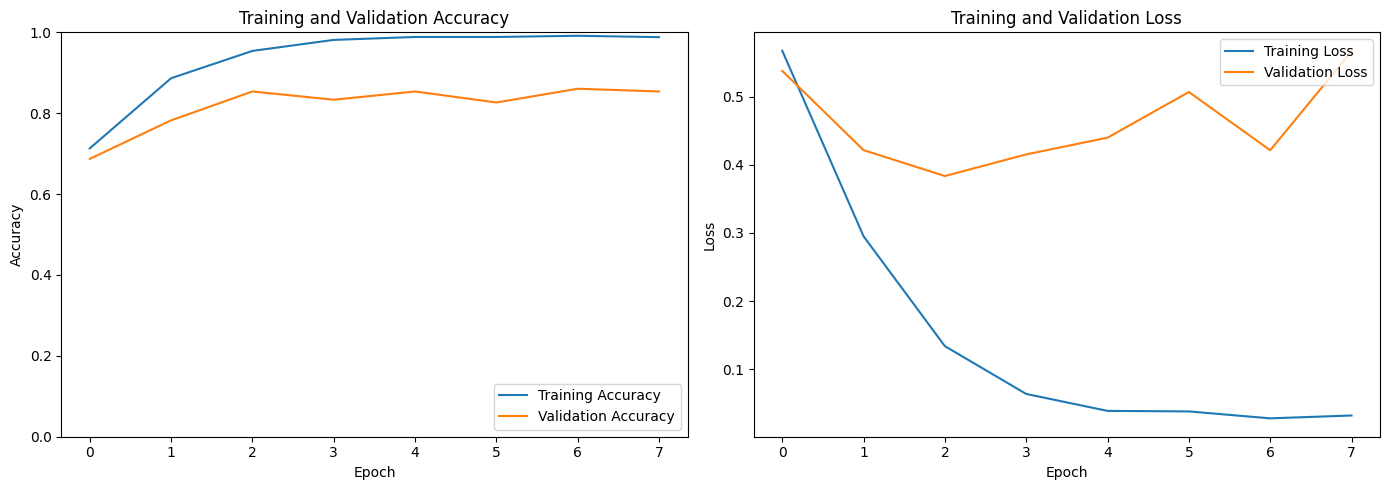

In [24]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis range from 0 to 1 for accuracy
plt.legend(loc='lower right')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import save_model

# Save your trained model
save_model(model, 'efficientnetb4_model.h5')

# Download the model to your local machine
from google.colab import files
files.download('efficientnetb4_model.h5')

<ipython-input-25-296626ae89e3>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model, 'efficientnetb4_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import roc_auc_score
import numpy as np

# Define the directories for training, testing, and validation
train_dir = "output/train"
test_dir = "output/test"
val_dir = "output/val"

# Create datasets for training, testing, and validation
train_data = image_dataset_from_directory(
    train_dir,
    batch_size=32,
    image_size=(224, 224),
    label_mode='categorical',
    shuffle=True,
    seed=42
)

test_data = image_dataset_from_directory(
    test_dir,
    batch_size=32,
    image_size=(224, 224),
    label_mode='categorical',
    shuffle=False,
    seed=42
)

val_data = image_dataset_from_directory(
    val_dir,
    batch_size=32,
    image_size=(224, 224),
    label_mode='categorical',
    shuffle=False,
    seed=42
)

class_names = train_data.class_names
class_count = len(class_names)

print("Class Names:", class_names)
print("Number of Classes:", class_count)

# Define EfficientNetB4 base model
base_model = tf.keras.applications.EfficientNetB4(
    include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling=None)

# Add GlobalAveragePooling2D layer to reduce the number of parameters
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(rate=0.5)(x)
output = Dense(class_count, activation='softmax')(x)

# Construct the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define EarlyStopping callback
early_stopper = tf.keras.callbacks.EarlyStopping(patience=5, min_delta=0.01, verbose=1, restore_best_weights=True)

# Train the model
history = model.fit(train_data,
                    epochs=60,
                    validation_data=val_data,
                    callbacks=[early_stopper])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data)
print("Test Accuracy:", test_accuracy)

# Make predictions on the test data
y_pred_probs = model.predict(test_data)

# Extract true labels from test data
y_true = np.concatenate([y.numpy() for x, y in test_data], axis=0)

# Calculate AUC for each class
auc = roc_auc_score(y_true, y_pred_probs, multi_class='ovr')
print("AUC Score:", auc)


Found 2352 files belonging to 2 classes.
Found 294 files belonging to 2 classes.
Found 294 files belonging to 2 classes.
Class Names: ['Autistic', 'Non_Autistic']
Number of Classes: 2
Epoch 1/60
74/74 [==============================] - 123s 739ms/step - loss: 0.5880 - accuracy: 0.6892 - val_loss: 0.5690 - val_accuracy: 0.6939
Epoch 2/60
74/74 [==============================] - 52s 701ms/step - loss: 0.3129 - accuracy: 0.8648 - val_loss: 0.5749 - val_accuracy: 0.7619
Epoch 3/60
74/74 [==============================] - 51s 690ms/step - loss: 0.1554 - accuracy: 0.9469 - val_loss: 0.3911 - val_accuracy: 0.8231
Epoch 4/60
74/74 [==============================] - 52s 694ms/step - loss: 0.0752 - accuracy: 0.9775 - val_loss: 0.4188 - val_accuracy: 0.8401
Epoch 5/60
74/74 [==============================] - 51s 684ms/step - loss: 0.0420 - accuracy: 0.9889 - val_loss: 0.4649 - val_accuracy: 0.8435
Epoch 6/60
74/74 [==============================] - 52s 695ms/step - loss: 0.0341 - accuracy: 0.9911

1/1 [==============================] - 4s 4s/step


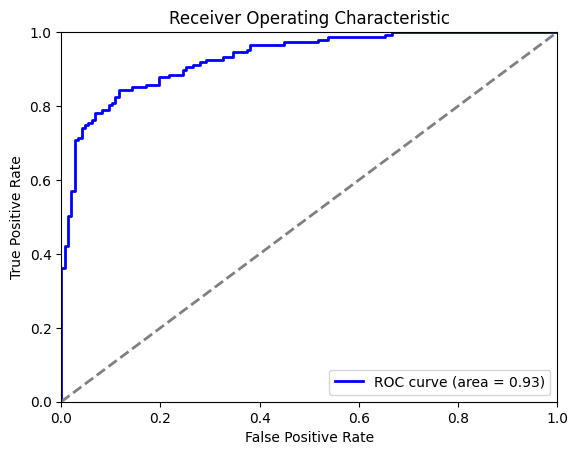

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import tensorflow as tf

# Assuming you have a trained model named `model`

# Get the true labels and predictions for the validation set
y_true = []
y_pred = []

for images, labels in val_data:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(predictions)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# If you have categorical labels, convert them to binary for ROC AUC computation
# Assuming binary classification for simplicity. Adjust for multi-class if necessary
y_true_binary = y_true[:, 1]  # Assuming the positive class is at index 1
y_pred_binary = y_pred[:, 1]  # Assuming the positive class is at index 1

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true_binary, y_pred_binary)
auc = roc_auc_score(y_true_binary, y_pred_binary)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')  # Corrected line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()